In [1]:
import librosa
audio_file_path='UrbanSound8K/14113-4-0-0.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [2]:
librosa_audio_data

array([ 0.00144175,  0.00172319,  0.00085848, ..., -0.00334668,
       -0.00736269, -0.00106208], dtype=float32)

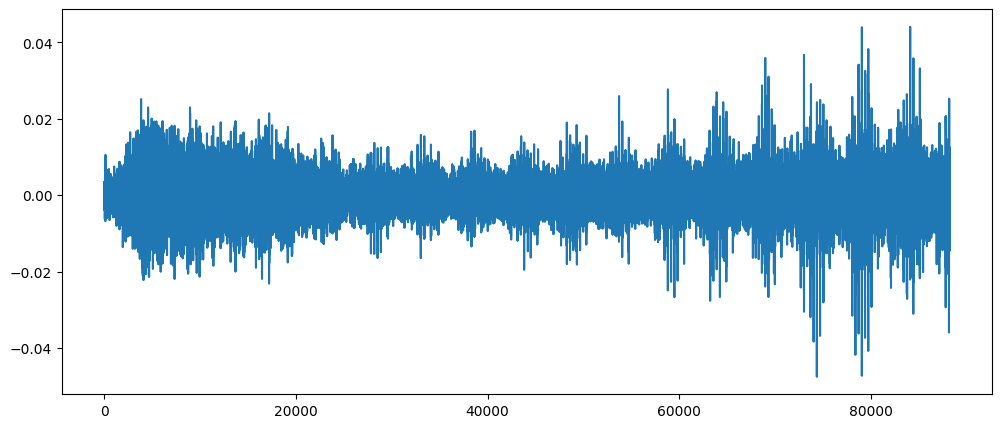

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(librosa_audio_data)

In [4]:
from scipy.io import wavfile as wav
wave_sample_rate,wave_audio=wav.read(audio_file_path)

In [5]:
wave_audio

array([[ 101,   27],
       [  93,   17],
       [ 113,    1],
       ...,
       [ -35, -316],
       [  68, -137],
       [  59,   56]], dtype=int16)

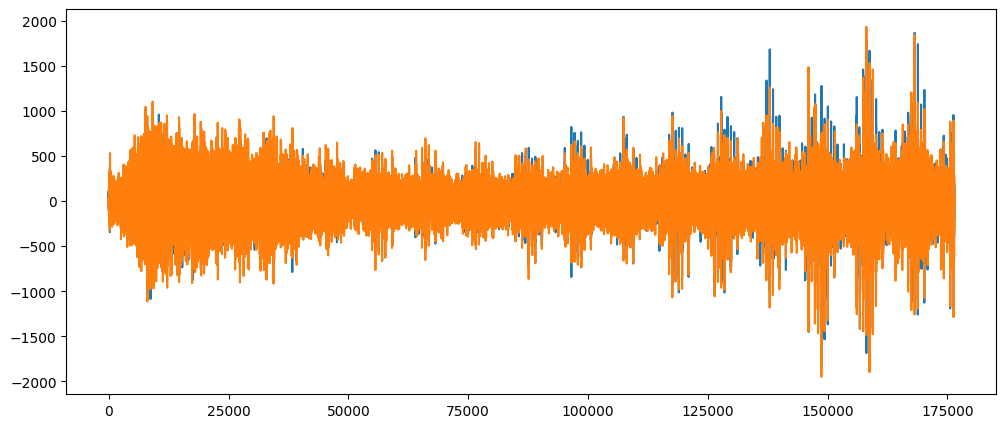

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(wave_audio)
# this is because of two channels

### Extract Features

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [7]:
mfccs=librosa.feature.mfcc(y=librosa_audio_data,sr=librosa_sample_rate,n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [8]:
mfccs

array([[-418.20755   , -400.03558   , -402.3668    , ..., -336.27975   ,
        -314.1584    , -312.0838    ],
       [  48.440628  ,   52.854248  ,   47.412228  , ...,   50.91221   ,
          48.225     ,   42.674755  ],
       [ -18.611887  ,  -25.481785  ,  -36.24078   , ...,  -33.554787  ,
         -26.005089  ,  -18.427639  ],
       ...,
       [  -3.382289  ,    1.2117375 ,    5.7348666 , ...,    5.2950063 ,
           2.0421224 ,    1.3319566 ],
       [  -5.415906  ,   -3.2792308 ,   -0.8630369 , ...,   -4.6687317 ,
          -4.2101116 ,   -6.5054927 ],
       [   0.73280245,   -0.7426889 ,   -3.5831196 , ...,   -2.3524241 ,
           1.4678818 ,    1.1627387 ]], dtype=float32)

In [9]:
import pandas as pd
import os
import librosa

audio_dataset_path='UrbanSound8K/audio'

metadata=pd.read_csv('UrbanSound8k/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [10]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
 

In [11]:
import numpy as np
from tqdm import tqdm
import librosa
import resampy
import lazy_loader
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [04:44, 10.89it/s]C:\Users\Acer\anaconda3\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8324it [10:41, 17.42it/s]C:\Users\Acer\anaconda3\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [11:09, 13.03it/s]


In [12]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing


In [13]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [14]:
X.shape

(8732, 40)

In [15]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [16]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [17]:
y


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [19]:
X_train


array([[-1.31104706e+02,  1.12505905e+02, -2.25746956e+01, ...,
         3.24665213e+00, -1.36902368e+00,  2.75575471e+00],
       [-1.36703424e+01,  9.10850830e+01, -7.79273367e+00, ...,
        -3.25305033e+00, -5.27745295e+00, -1.55697155e+00],
       [-4.98715439e+01,  2.65352994e-01, -2.05009365e+01, ...,
         2.85459447e+00, -1.60920441e+00,  3.52480578e+00],
       ...,
       [-4.27012360e+02,  9.26230469e+01,  3.12939739e+00, ...,
         7.42641211e-01,  7.33490884e-01,  7.11009145e-01],
       [-1.45754608e+02,  1.36265778e+02, -3.35155182e+01, ...,
         1.46811938e+00, -2.00917006e+00, -8.82181883e-01],
       [-4.21031342e+02,  2.10654541e+02,  3.49066091e+00, ...,
        -5.38886690e+00, -3.37136054e+00, -1.56651139e+00]], dtype=float32)

In [20]:
y


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
X_train.shape


(6985, 40)

In [22]:
X_test.shape

(1747, 40)

In [23]:
y_train.shape


(6985, 10)

In [24]:
y_test.shape


(1747, 10)

## MODEL CREATION

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [26]:
### No of classes
num_labels=y.shape[1]

In [27]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [28]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [29]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [30]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
215/219 [============================>.] - ETA: 0s - loss: 12.5140 - accuracy: 0.1203
Epoch 1: val_loss improved from inf to 2.29119, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 3s 8ms/step - loss: 12.3699 - accuracy: 0.1198 - val_loss: 2.2912 - val_accuracy: 0.1070
Epoch 2/100
218/219 [============================>.] - ETA: 0s - loss: 2.5877 - accuracy: 0.1124
Epoch 2: val_loss improved from 2.29119 to 2.28120, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 6ms/step - loss: 2.5873 - accuracy: 0.1124 - val_loss: 2.2812 - val_accuracy: 0.1070
Epoch 3/100
207/219 [===========================>..] - ETA: 0s - loss: 2.3476 - accuracy: 0.1144
Epoch 3: val_loss improved from 2.28120 to 2.27435, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 7ms/step - loss: 2.3438 - accuracy: 0.1147 - val_loss: 2.2744 - val_accuracy: 0.10

Epoch 26/100
212/219 [============================>.] - ETA: 0s - loss: 1.5722 - accuracy: 0.4261
Epoch 26: val_loss improved from 1.43535 to 1.40126, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 1.5725 - accuracy: 0.4268 - val_loss: 1.4013 - val_accuracy: 0.5054
Epoch 27/100
210/219 [===========================>..] - ETA: 0s - loss: 1.5463 - accuracy: 0.4464
Epoch 27: val_loss improved from 1.40126 to 1.36669, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 6ms/step - loss: 1.5475 - accuracy: 0.4464 - val_loss: 1.3667 - val_accuracy: 0.5306
Epoch 28/100
219/219 [==============================] - ETA: 0s - loss: 1.5355 - accuracy: 0.4484
Epoch 28: val_loss improved from 1.36669 to 1.33735, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 6ms/step - loss: 1.5355 - accuracy: 0.4484 - val_loss: 1.3373 - val_accura

219/219 [==============================] - 1s 6ms/step - loss: 1.1547 - accuracy: 0.6044 - val_loss: 0.9798 - val_accuracy: 0.6743
Epoch 52/100
219/219 [==============================] - ETA: 0s - loss: 1.1595 - accuracy: 0.6021
Epoch 52: val_loss did not improve from 0.97985
219/219 [==============================] - 1s 6ms/step - loss: 1.1595 - accuracy: 0.6021 - val_loss: 0.9969 - val_accuracy: 0.6703
Epoch 53/100
213/219 [============================>.] - ETA: 0s - loss: 1.1763 - accuracy: 0.5989
Epoch 53: val_loss improved from 0.97985 to 0.97482, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 7ms/step - loss: 1.1747 - accuracy: 0.5986 - val_loss: 0.9748 - val_accuracy: 0.6732
Epoch 54/100
219/219 [==============================] - ETA: 0s - loss: 1.1424 - accuracy: 0.6105
Epoch 54: val_loss did not improve from 0.97482
219/219 [==============================] - 1s 6ms/step - loss: 1.1424 - accuracy: 0.6105 - val_loss: 0.9833 -

Epoch 79/100
214/219 [============================>.] - ETA: 0s - loss: 1.0077 - accuracy: 0.6603
Epoch 79: val_loss improved from 0.83966 to 0.82912, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 6ms/step - loss: 1.0068 - accuracy: 0.6597 - val_loss: 0.8291 - val_accuracy: 0.7361
Epoch 80/100
211/219 [===========================>..] - ETA: 0s - loss: 1.0159 - accuracy: 0.6545
Epoch 80: val_loss improved from 0.82912 to 0.82009, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 6ms/step - loss: 1.0135 - accuracy: 0.6561 - val_loss: 0.8201 - val_accuracy: 0.7321
Epoch 81/100
209/219 [===========================>..] - ETA: 0s - loss: 1.0352 - accuracy: 0.6492
Epoch 81: val_loss did not improve from 0.82009
219/219 [==============================] - 1s 5ms/step - loss: 1.0402 - accuracy: 0.6487 - val_loss: 0.8237 - val_accuracy: 0.7264
Epoch 82/100
214/219 [===========================

In [31]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7607327103614807


In [32]:
filename="UrbanSound8K/dog_bark.wav"
prediction_feature=features_extractor(filename)
prediction_feature=prediction_feature.reshape(1,-1)
model.predict(prediction_feature)

1/1 [==============================] - 0s 233ms/step


array([[1.8012033e-04, 6.2077427e-01, 4.8164834e-04, 3.1502977e-02,
        3.3803456e-02, 1.9281429e-03, 2.1789376e-04, 1.6268707e-03,
        5.9339061e-04, 3.0889124e-01]], dtype=float32)

In [33]:
model.predict(X_test)


55/55 [==============================] - 0s 3ms/step


array([[1.21306488e-03, 1.51527085e-04, 7.47996499e-04, ...,
        1.51035739e-09, 1.51939355e-04, 3.23738903e-03],
       [4.03595004e-14, 1.11164672e-05, 1.51688780e-03, ...,
        6.21241386e-16, 2.75587547e-04, 9.18141632e-06],
       [6.44229732e-13, 1.45841521e-04, 4.90977170e-09, ...,
        2.80195642e-02, 1.54743426e-10, 2.37286858e-05],
       ...,
       [3.65834353e-07, 9.34002995e-01, 1.96359088e-06, ...,
        2.18796075e-08, 5.88401235e-05, 5.21292649e-02],
       [1.20335296e-01, 1.54982070e-02, 2.30677143e-01, ...,
        9.96874925e-03, 9.96466447e-03, 4.46881384e-01],
       [2.20682919e-01, 1.12021277e-02, 1.91790044e-01, ...,
        1.62592309e-03, 4.63614874e-02, 1.75720528e-01]], dtype=float32)

In [34]:
prediction_feature.shape


(1, 40)

### TESTING SOME TEST AUDIO DATA

In [35]:
filename="UrbanSound8K/14113-4-0-0.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-3.5755768e+02  5.2384941e+01 -4.1709915e+01  4.3974850e+01
 -1.6069826e+01  9.7353554e+00 -5.0241313e+00  1.0326746e+01
 -1.6136753e+01  2.6916557e+01 -1.4883501e+01  1.9002371e+01
 -1.3996512e+01  6.6752758e+00 -1.7345709e+01  7.7119689e+00
 -1.6728809e+01  1.0445916e+01 -1.6504908e+01  1.0037302e+01
 -6.7588983e+00  3.2604737e+00 -6.0810432e+00  4.5140672e+00
 -4.7407556e+00 -5.8550125e-01 -3.1900074e+00  4.0783095e+00
 -3.4920244e+00  3.5106187e+00 -5.0360990e+00  1.5612837e+00
 -4.6750488e+00  3.6949618e+00 -3.9920719e+00  4.5324945e+00
 -3.9963012e+00  2.9155529e+00 -3.2510986e+00 -2.3989033e-02]
[[-3.5755768e+02  5.2384941e+01 -4.1709915e+01  4.3974850e+01
  -1.6069826e+01  9.7353554e+00 -5.0241313e+00  1.0326746e+01
  -1.6136753e+01  2.6916557e+01 -1.4883501e+01  1.9002371e+01
  -1.3996512e+01  6.6752758e+00 -1.7345709e+01  7.7119689e+00
  -1.6728809e+01  1.0445916e+01 -1.6504908e+01  1.0037302e+01
  -6.7588983e+00  3.2604737e+00 -6.0810432e+00  4.5140672e+00
  -4.7407556e+00 

ValueError: y should be a 1d array, got an array of shape (1, 10) instead.